In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')


In [1]:
import wandb
from wandb.integration.keras import WandbCallback  # ✅ correct import
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Get W&B API key from environment
wandb_api = os.getenv("WANDB_API_KEY")

# Login to W&B
wandb.login(key=wandb_api)


wandb: Currently logged in as: shyampandu181 (shyampandu181-kalasalingam-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
train_dir = "Original Image"

SEED = 12
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 15
EPOCHS = 30
#FINE_TUNING_EPOCHS = 20
LR = 0.01
CLASS_LABELS  =  os.listdir("Original Image")
NUM_CLASSES = len(CLASS_LABELS)
EARLY_STOPPING_CRITERIA=3


CONFIG = dict (
    SEED = 12,
    IMG_HEIGHT = 512,
    IMG_WIDTH = 512,
    BATCH_SIZE =15,
    EPOCHS = 30,
    #FINE_TUNING_EPOCHS = 20,
    LR = 0.01,
    CLASS_LABELS  =  os.listdir("Original Image"),
    NUM_CLASSES = len(CLASS_LABELS),
    EARLY_STOPPING_CRITERIA=3,
)    

In [4]:
train_datagen = ImageDataGenerator(
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                  )
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,   
                                 )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = SEED
                                                   )

valid_generator = valid_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = False , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = SEED
                                                        )


Found 374 images belonging to 4 classes.
Found 92 images belonging to 4 classes.


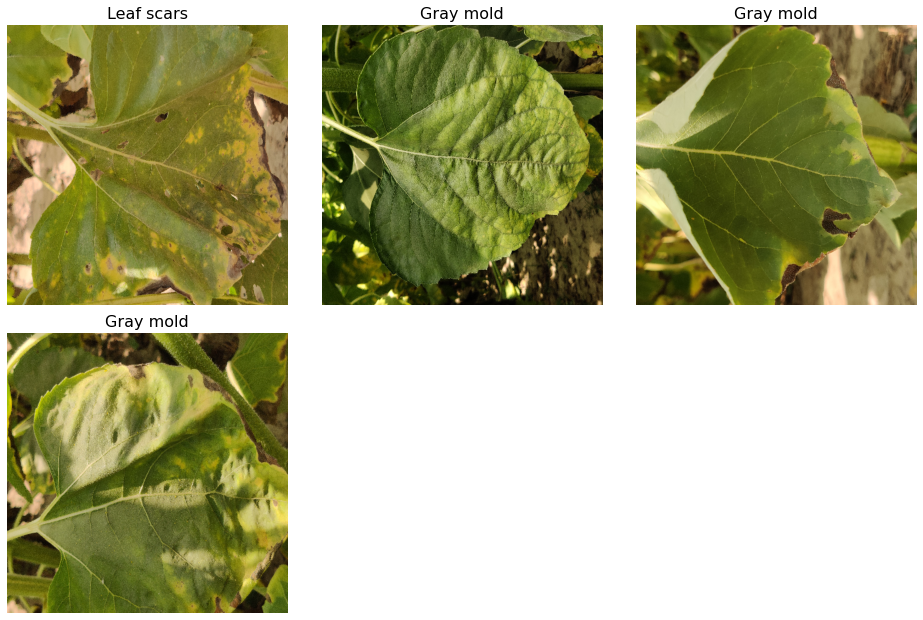

In [5]:
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(NUM_CLASSES):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors


images, classes = next(train_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [6]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="magenta") 
fig.update_xaxes(title="Plant Images")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [7]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation=tf.nn.silu, 
                             kernel_regularizer = tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [8]:
model = define_compile_model()
clear_output()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
classification (Dense)       (None, 4)                 2052  

In [9]:
CONFIG['model_name'] = 'densenet121'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='plant-images', 
                 config=CONFIG,
                 group='densenet121', 
                 job_type='train')

wandb: Currently logged in as: satellite-image-classification (use `wandb login --relogin` to force relogin)


Training configuration:  {'SEED': 12, 'IMG_HEIGHT': 512, 'IMG_WIDTH': 512, 'BATCH_SIZE': 15, 'EPOCHS': 30, 'LR': 0.01, 'CLASS_LABELS': ['Gray mold', 'Downy mildew', 'Fresh Leaf', 'Leaf scars'], 'NUM_CLASSES': 4, 'EARLY_STOPPING_CRITERIA': 3, 'model_name': 'densenet121'}


In [10]:
wandb.config.type = 'baseline'

In [11]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = valid_generator , 
                    #callbacks= [earlyStoppingCallback]
                    callbacks=[WandbCallback()]
                   )

run.finish()

history = pd.DataFrame(history.history)

2022-07-06 09:00:06.135983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-07-06 09:00:20.875183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 143s 5s/step - loss: 0.6774 - accuracy: 0.7353 - val_loss: 0.9935 - val_accuracy: 0.5761
Epoch 2/30
25/25 [==============================] - 100s 4s/step - loss: 0.1846 - accuracy: 0.9545 - val_loss: 0.8167 - val_accuracy: 0.5978
Epoch 3/30
25/25 [==============================] - 100s 4s/step - loss: 0.1045 - accuracy: 0.9813 - val_loss: 0.7208 - val_accuracy: 0.6630
Epoch 4/30
25/25 [==============================] - 100s 4s/step - loss: 0.0755 - accuracy: 0.9920 - val_loss: 0.6994 - val_accuracy: 0.6413
Epoch 5/30
25/25 [==============================] - 101s 4s/step - loss: 0.0498 - accuracy: 0.9920 - val_loss: 0.5757 - val_accuracy: 0.7391
Epoch 6/30
25/25 [==============================] - 100s 4s/step - loss: 0.0433 - accuracy: 0.9973 - val_loss: 0.4657 - val_accuracy: 0.8261
Epoch 7/30
25/25 [==============================] - 100s 4s/step - loss: 0.0354 - accuracy: 0.9973 - val_loss: 0.4057 - val_accuracy: 0.8696
Epoch 8/30
25/25 [======

accuracy,▁▇████████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▂▄▆▇▇▇▇▇▇█████▇▇▇█▇▇███████
val_loss,█▇▆▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
best_epoch,16
best_val_loss,0.15746
epoch,29
loss,0.0128
val_accuracy,0.92391


In [12]:
preds = model.predict(valid_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(valid_generator.labels)
def multiclass_roc_auc_score_wb(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return roc_auc_score(y_test, y_pred, average=average)

auc = multiclass_roc_auc_score_wb(y_test , preds  , average = "micro")

In [13]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='plant-images', 
                 config=CONFIG,
                 group='densenet121', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
loss, acc = model.evaluate(valid_generator)

# Log scores using wandb.log()
wandb.log({'val_accuracy': acc, 
           'loss': loss,
          "auc": auc })

# Finish the run
run.finish()

7/7 [==============================] - 19s 3s/step - loss: 0.1656 - accuracy: 0.9239



auc,▁
loss,▁
val_accuracy,▁
auc,0.99579
loss,0.16559
val_accuracy,0.92391


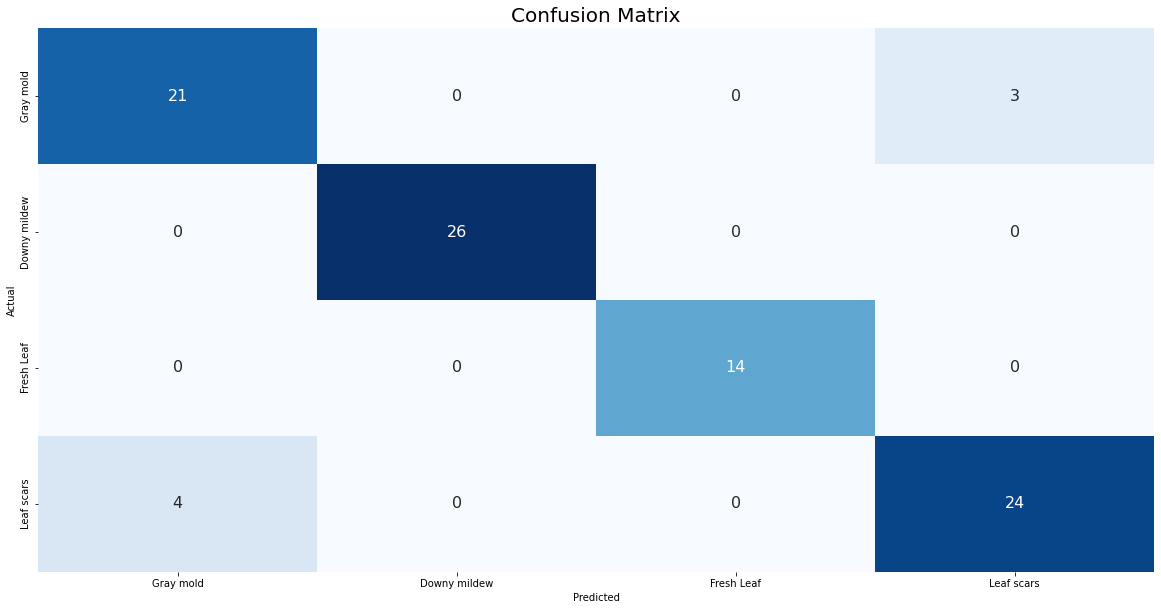

In [14]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [15]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        24
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        14
           3       0.89      0.86      0.87        28

    accuracy                           0.92        92
   macro avg       0.93      0.93      0.93        92
weighted avg       0.92      0.92      0.92        92



ROC AUC score: 0.9957860743541274


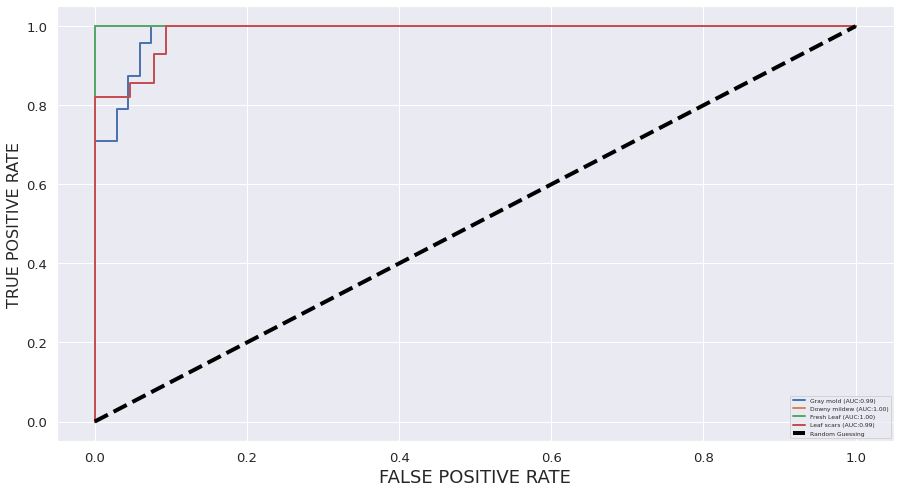

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 6)
plt.show()

In [17]:
model.save('densenet121-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='plant-images', 
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='densenet121', type='model')
artifact.add_file('densenet121-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()